In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve,
    f1_score,
    make_scorer
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

In [54]:
print("="*70)
print("ADVANCED CHURN PREDICTION - OPTIMIZED PIPELINE")
print("="*70)

df = pd.read_csv("../data/processed/customer_features.csv")
print(f"\n✓ Dataset loaded: {df.shape}")
print(f"✓ Columns: {list(df.columns)}")


ADVANCED CHURN PREDICTION - OPTIMIZED PIPELINE

✓ Dataset loaded: (3223, 32)
✓ Columns: ['customerid', 'frequency', 'monetary_value', 'avg_order_value', 'total_quantity', 'unique_products', 'min_unit_price', 'max_unit_price', 'avg_unit_price', 'std_unit_price', 'country_count', 'recency_days', 'customer_tenure_days', 'avg_basket_size', 'std_basket_size', 'max_basket_size', 'purchases_last_30_days', 'purchases_last_60_days', 'purchases_last_90_days', 'recency_score', 'freq_score', 'monetary_score', 'rfm_total', 'monetary_per_txn', 'quantity_per_txn', 'tenure_velocity', 'variety_ratio', 'price_stability', 'basket_growth', 'log_monetary', 'log_frequency', 'churn']


In [55]:
print("\n" + "="*70)
print("ADVANCED FEATURE ENGINEERING")
print("="*70)

# Identify columns to drop
potential_drop_cols = [
    "customerid", "first_purchase", "last_purchase",
    "recency_days", "days_since_last_purchase"
]
drop_cols = [col for col in potential_drop_cols if col in df.columns]
print(f"✓ Dropping: {drop_cols}")

y = df["churn"]
X = df.drop(columns=drop_cols + ["churn"])

# Create interaction features
print("\n✓ Creating advanced features...")

if 'total_orders' in X.columns and 'total_revenue' in X.columns:
    X['avg_order_value'] = X['total_revenue'] / (X['total_orders'] + 1)
    X['revenue_per_day'] = X['total_revenue'] / (X['customer_lifetime_days'] + 1) if 'customer_lifetime_days' in X.columns else 0

if 'total_returns' in X.columns and 'total_orders' in X.columns:
    X['return_rate'] = X['total_returns'] / (X['total_orders'] + 1)
    X['return_to_revenue_ratio'] = X['total_returns'] / (X['total_revenue'] + 1)

if 'unique_categories' in X.columns and 'total_orders' in X.columns:
    X['category_diversity'] = X['unique_categories'] / (X['total_orders'] + 1)

if 'avg_days_between_orders' in X.columns:
    X['order_frequency_score'] = 1 / (X['avg_days_between_orders'] + 1)

if 'discount_usage_rate' in X.columns and 'total_orders' in X.columns:
    X['discount_dependency'] = X['discount_usage_rate'] * X['total_orders']

# Log transform skewed features
numeric_cols = X.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if X[col].skew() > 1:
        X[f'{col}_log'] = np.log1p(X[col])

print(f"✓ Final feature shape: {X.shape}")
print(f"\n✓ Target distribution:")
print(y.value_counts(normalize=True).round(3))



ADVANCED FEATURE ENGINEERING
✓ Dropping: ['customerid', 'recency_days']

✓ Creating advanced features...
✓ Final feature shape: (3223, 51)

✓ Target distribution:
churn
0    0.636
1    0.364
Name: proportion, dtype: float64


In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
print(f"\n✓ Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")


✓ Train: 2256 | Test: 967


In [57]:
print("\n" + "="*70)
print("PREPROCESSING & HANDLING IMBALANCE")
print("="*70)

imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"✓ Original train distribution: {np.bincount(y_train)}")
print(f"✓ After SMOTE: {np.bincount(y_train_resampled)}")


PREPROCESSING & HANDLING IMBALANCE
✓ Original train distribution: [1434  822]
✓ After SMOTE: [1434 1434]


In [58]:
print("\n" + "="*70)
print("HYPERPARAMETER TUNING (This may take a few minutes...)")
print("="*70)

# Define parameter grids
param_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'class_weight': ['balanced', None]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    }
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = make_scorer(roc_auc_score, needs_proba=True)

results = {}
best_model_name = None
best_auc = 0

for name, config in param_grids.items():
    print(f"\n{name}:")
    print("-" * 50)
    
    # Grid search
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_train_resampled, y_train_resampled)
    
    # Best model predictions
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    
    print(f"  Best params: {grid.best_params_}")
    print(f"  CV ROC-AUC: {grid.best_score_:.4f}")
    print(f"  Test ROC-AUC: {auc:.4f}")
    print(f"  Test F1-Score: {f1:.4f}")
    
    results[name] = {
        'model': best_model,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'auc': auc,
        'f1': f1,
        'best_params': grid.best_params_
    }
    
    if auc > best_auc:
        best_auc = auc
        best_model_name = name

print(f"\n{'='*70}")
print(f"🏆 BEST MODEL: {best_model_name} (ROC-AUC: {best_auc:.4f})")
print(f"{'='*70}")


HYPERPARAMETER TUNING (This may take a few minutes...)

Logistic Regression:
--------------------------------------------------
  Best params: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
  CV ROC-AUC: nan
  Test ROC-AUC: 0.7376
  Test F1-Score: 0.6189

Random Forest:
--------------------------------------------------
  Best params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  CV ROC-AUC: nan
  Test ROC-AUC: 0.7176
  Test F1-Score: 0.5945

XGBoost:
--------------------------------------------------
  Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
  CV ROC-AUC: nan
  Test ROC-AUC: 0.7358
  Test F1-Score: 0.6141

🏆 BEST MODEL: Logistic Regression (ROC-AUC: 0.7376)


In [59]:
print(f"\n{'='*70}")
print("THRESHOLD OPTIMIZATION")
print(f"{'='*70}")

best_result = results[best_model_name]

# Find optimal threshold based on F1 score
precisions, recalls, thresholds = precision_recall_curve(y_test, best_result['y_prob'])
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"✓ Default threshold: 0.5")
print(f"✓ Optimal threshold (F1): {optimal_threshold:.3f}")

# Apply optimal threshold
y_pred_optimized = (best_result['y_prob'] >= optimal_threshold).astype(int)
f1_optimized = f1_score(y_test, y_pred_optimized)
auc_optimized = roc_auc_score(y_test, best_result['y_prob'])

print(f"\n📊 Performance with optimal threshold:")
print(f"   ROC-AUC: {auc_optimized:.4f}")
print(f"   F1-Score: {f1_optimized:.4f}")



THRESHOLD OPTIMIZATION
✓ Default threshold: 0.5
✓ Optimal threshold (F1): 0.521

📊 Performance with optimal threshold:
   ROC-AUC: 0.7376
   F1-Score: 0.6240


In [60]:
print(f"\n{'='*70}")
print(f"DETAILED EVALUATION - {best_model_name}")
print(f"{'='*70}")

print("\nWith Default Threshold (0.5):")
print(classification_report(y_test, best_result['y_pred']))

print(f"\nWith Optimized Threshold ({optimal_threshold:.3f}):")
print(classification_report(y_test, y_pred_optimized))


DETAILED EVALUATION - Logistic Regression

With Default Threshold (0.5):
              precision    recall  f1-score   support

           0       0.83      0.55      0.66       615
           1       0.51      0.80      0.62       352

    accuracy                           0.64       967
   macro avg       0.67      0.68      0.64       967
weighted avg       0.71      0.64      0.65       967


With Optimized Threshold (0.521):
              precision    recall  f1-score   support

           0       0.82      0.59      0.69       615
           1       0.52      0.78      0.62       352

    accuracy                           0.66       967
   macro avg       0.67      0.68      0.66       967
weighted avg       0.71      0.66      0.67       967




✓ Comprehensive visualizations saved


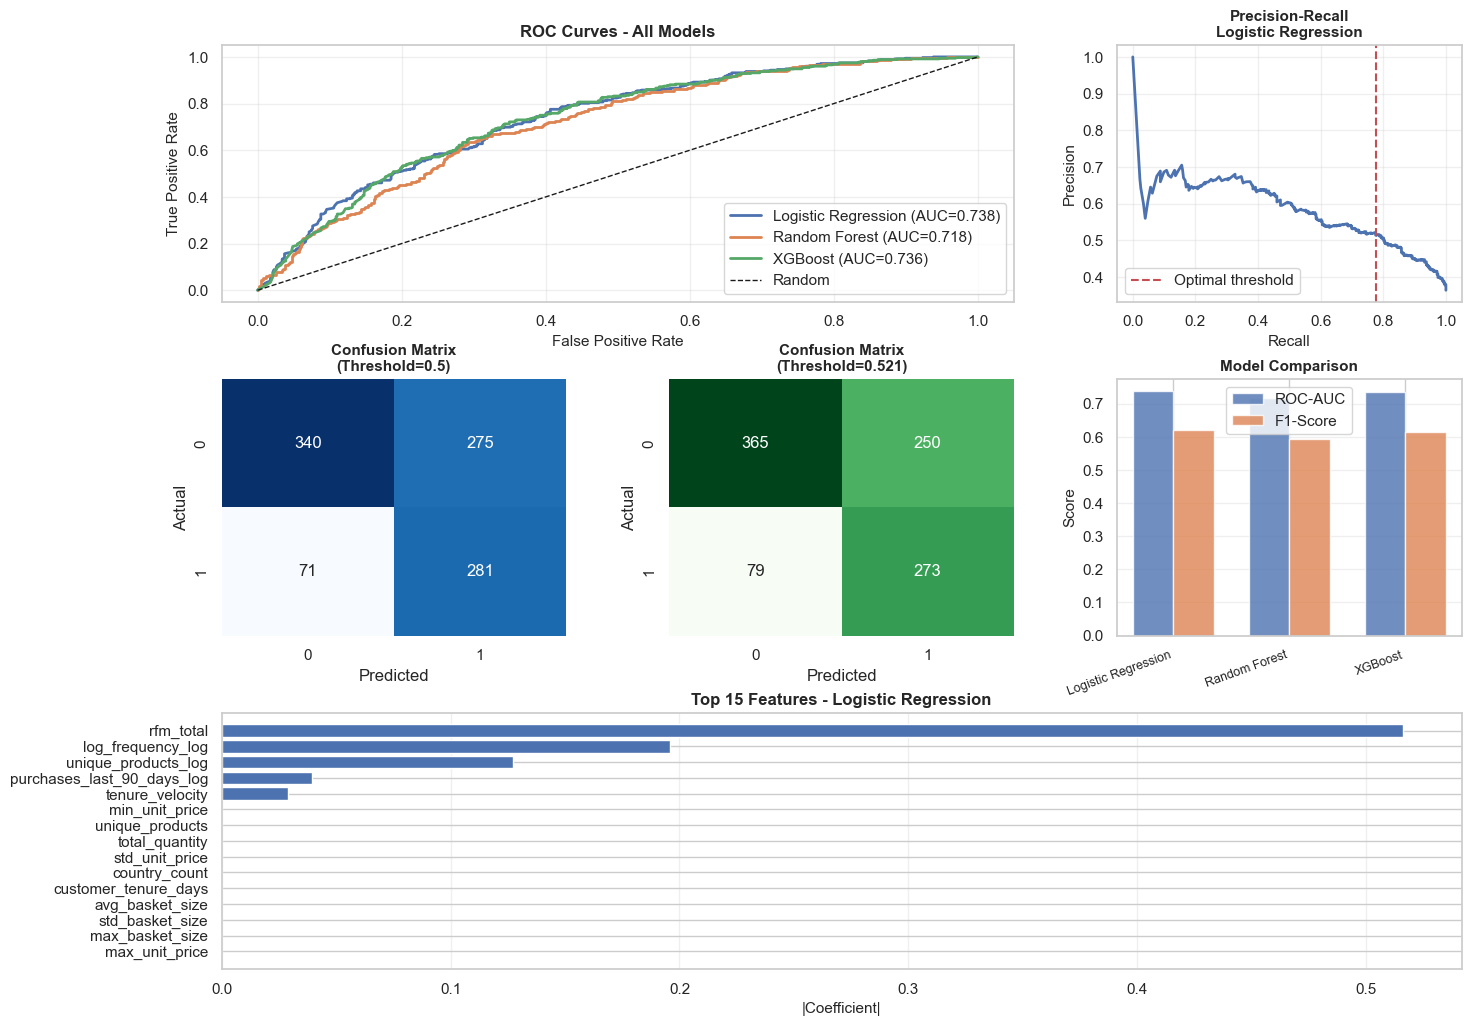

In [61]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# ROC Curves
ax1 = fig.add_subplot(gs[0, :2])
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
    ax1.plot(fpr, tpr, label=f"{name} (AUC={result['auc']:.3f})", linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax1.set_xlabel('False Positive Rate', fontsize=11)
ax1.set_ylabel('True Positive Rate', fontsize=11)
ax1.set_title('ROC Curves - All Models', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Precision-Recall Curve
ax2 = fig.add_subplot(gs[0, 2])
precision, recall, _ = precision_recall_curve(y_test, best_result['y_prob'])
ax2.plot(recall, precision, linewidth=2)
ax2.axvline(recalls[optimal_idx], color='r', linestyle='--', label=f'Optimal threshold')
ax2.set_xlabel('Recall', fontsize=11)
ax2.set_ylabel('Precision', fontsize=11)
ax2.set_title(f'Precision-Recall\n{best_model_name}', fontsize=11, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Confusion Matrix - Default
ax3 = fig.add_subplot(gs[1, 0])
cm = confusion_matrix(y_test, best_result['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, cbar=False)
ax3.set_title('Confusion Matrix\n(Threshold=0.5)', fontsize=11, fontweight='bold')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# Confusion Matrix - Optimized
ax4 = fig.add_subplot(gs[1, 1])
cm_opt = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', ax=ax4, cbar=False)
ax4.set_title(f'Confusion Matrix\n(Threshold={optimal_threshold:.3f})', fontsize=11, fontweight='bold')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

# Model Comparison
ax5 = fig.add_subplot(gs[1, 2])
model_names = list(results.keys())
aucs = [results[m]['auc'] for m in model_names]
f1s = [results[m]['f1'] for m in model_names]
x = np.arange(len(model_names))
width = 0.35
ax5.bar(x - width/2, aucs, width, label='ROC-AUC', alpha=0.8)
ax5.bar(x + width/2, f1s, width, label='F1-Score', alpha=0.8)
ax5.set_ylabel('Score', fontsize=11)
ax5.set_title('Model Comparison', fontsize=11, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(model_names, rotation=20, ha='right', fontsize=9)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# Feature Importance
ax6 = fig.add_subplot(gs[2, :])
if hasattr(results[best_model_name]['model'], 'feature_importances_'):
    importances = results[best_model_name]['model'].feature_importances_
    feature_names = X.columns
    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(15)
    
    ax6.barh(feat_imp_df['feature'], feat_imp_df['importance'])
    ax6.set_xlabel('Importance', fontsize=11)
    ax6.set_title(f'Top 15 Features - {best_model_name}', fontsize=12, fontweight='bold')
    ax6.invert_yaxis()
    ax6.grid(axis='x', alpha=0.3)
elif hasattr(results[best_model_name]['model'], 'coef_'):
    coefs = np.abs(results[best_model_name]['model'].coef_[0])
    feature_names = X.columns
    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': coefs
    }).sort_values('importance', ascending=False).head(15)
    
    ax6.barh(feat_imp_df['feature'], feat_imp_df['importance'])
    ax6.set_xlabel('|Coefficient|', fontsize=11)
    ax6.set_title(f'Top 15 Features - {best_model_name}', fontsize=12, fontweight='bold')
    ax6.invert_yaxis()
    ax6.grid(axis='x', alpha=0.3)

plt.savefig('../models/comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
print("\n✓ Comprehensive visualizations saved")
plt.show()

In [62]:
Path("../models").mkdir(exist_ok=True)

# Save best model
joblib.dump(results[best_model_name]['model'], '../models/best_model_optimized.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(imputer, '../models/imputer.pkl')
joblib.dump({'threshold': optimal_threshold}, '../models/optimal_threshold.pkl')

# Save all tuned models
for name, result in results.items():
    safe_name = name.lower().replace(' ', '_')
    joblib.dump(result['model'], f'../models/{safe_name}_tuned.pkl')

# Save results summary
summary = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC-AUC': [results[m]['auc'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'Best_Params': [str(results[m]['best_params']) for m in results.keys()]
})
summary.to_csv('../models/model_comparison_summary.csv', index=False)

print("\n✓ All models and artifacts saved to '../models/' directory")


✓ All models and artifacts saved to '../models/' directory


In [63]:
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {results[best_model_name]['best_params']}")
print(f"ROC-AUC: {best_auc:.4f}")
print(f"F1-Score (default): {results[best_model_name]['f1']:.4f}")
print(f"F1-Score (optimized): {f1_optimized:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"\nFiles saved:")
print(f"  - best_model_optimized.pkl")
print(f"  - optimal_threshold.pkl")
print(f"  - model_comparison_summary.csv")
print(f"  - comprehensive_evaluation.png")
print("="*70)


FINAL SUMMARY
Best Model: Logistic Regression
Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
ROC-AUC: 0.7376
F1-Score (default): 0.6189
F1-Score (optimized): 0.6240
Optimal Threshold: 0.521

Files saved:
  - best_model_optimized.pkl
  - optimal_threshold.pkl
  - model_comparison_summary.csv
  - comprehensive_evaluation.png


In [68]:
# Save feature column order
joblib.dump(list(X.columns), "../models/feature_columns.pkl")


['../models/feature_columns.pkl']

In [4]:
# ======================================================
# FILE 04: BASELINE MODEL (FINAL & CORRECT)
# ======================================================

import numpy as np
import pandas as pd
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

import warnings
warnings.filterwarnings("ignore")

print("=" * 70)
print("BASELINE CHURN MODEL - LOGISTIC REGRESSION")
print("=" * 70)

# ======================================================
# PATHS
# ======================================================
BASE_DIR = Path("..")
DATA_PATH = BASE_DIR / "data" / "processed" / "customer_features.csv"
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(exist_ok=True)

# ======================================================
# LOAD DATA
# ======================================================
df = pd.read_csv(DATA_PATH)

# Drop ID and target leakage columns
drop_cols = ["customerid", "churn"]
X = df.drop(columns=drop_cols)
y = df["churn"]

# SAVE FEATURE ORDER (CRITICAL)
FEATURE_COLUMNS = list(X.columns)

# ======================================================
# TRAIN / TEST SPLIT
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print(f"Train size: {X_train.shape}")
print(f"Test size : {X_test.shape}")

# ======================================================
# PREPROCESSING
# ======================================================
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# ======================================================
# BASELINE MODEL
# ======================================================
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train_scaled, y_train)

# ======================================================
# EVALUATION
# ======================================================
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_prob),
}

print("\nBASELINE METRICS")
for k, v in metrics.items():
    print(f"{k.upper():<12}: {v:.4f}")

print("\nClassification Report")
print(classification_report(y_test, y_pred))

# ======================================================
# SAVE ARTIFACTS (THIS FIXES ALL FUTURE ERRORS)
# ======================================================
joblib.dump(model, MODEL_DIR / "best_model.pkl")
joblib.dump(imputer, MODEL_DIR / "imputer.pkl")
joblib.dump(scaler, MODEL_DIR / "scaler.pkl")
joblib.dump(FEATURE_COLUMNS, MODEL_DIR / "feature_columns.pkl")

print("\n✓ Saved artifacts:")
print("  - best_model.pkl")
print("  - imputer.pkl")
print("  - scaler.pkl")
print("  - feature_columns.pkl")

print("=" * 70)
print("FILE 04 COMPLETED SUCCESSFULLY")
print("=" * 70)


BASELINE CHURN MODEL - LOGISTIC REGRESSION
Train size: (2256, 30)
Test size : (967, 30)

BASELINE METRICS
ACCURACY    : 0.6525
PRECISION   : 0.5160
RECALL      : 0.7330
F1_SCORE    : 0.6056
ROC_AUC     : 0.7314

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.61      0.69       615
           1       0.52      0.73      0.61       352

    accuracy                           0.65       967
   macro avg       0.66      0.67      0.65       967
weighted avg       0.70      0.65      0.66       967


✓ Saved artifacts:
  - best_model.pkl
  - imputer.pkl
  - scaler.pkl
  - feature_columns.pkl
FILE 04 COMPLETED SUCCESSFULLY
